In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

In [ ]:
def parser(s):
    return datetime.strptime(s, '%m-%d-%Y')

In [ ]:
#read data
path = '/content/resampled_daily_averages.csv'
bts_data = pd.read_csv(path)

In [ ]:
bts_data.head()

,Date,Load_Power(kW)
0,5/1/2021,6.675000
1,5/2/2021,6.579167
2,5/3/2021,6.504167
3,5/4/2021,6.770833
4,5/5/2021,6.837500


In [ ]:
# prompt: make the date column index and turn it to datetime data type

bts_data = bts_data.set_index('Date')
bts_data.index = pd.to_datetime(bts_data.index, format='%m/%d/%Y') # Use '/' as the separator in the format string


In [ ]:
#infer the frequency of the data
bts_data = bts_data.asfreq(pd.infer_freq(bts_data.index))

Text(0, 0.5, 'Power (kW)')

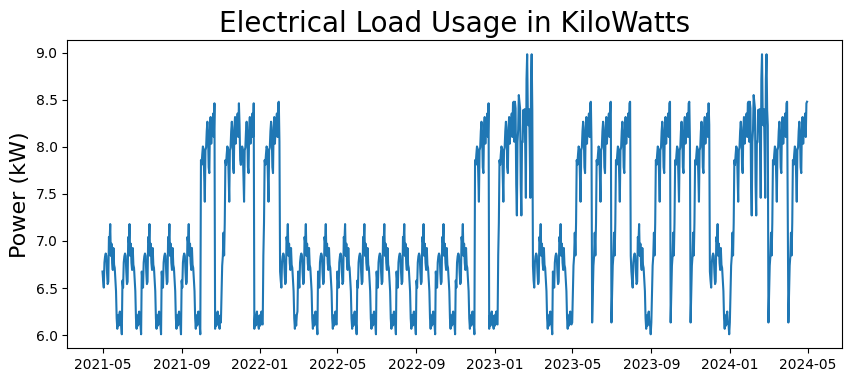

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(bts_data)
plt.title('Electrical Load Usage in KiloWatts', fontsize=20)
plt.ylabel('Power (kW)', fontsize=16)


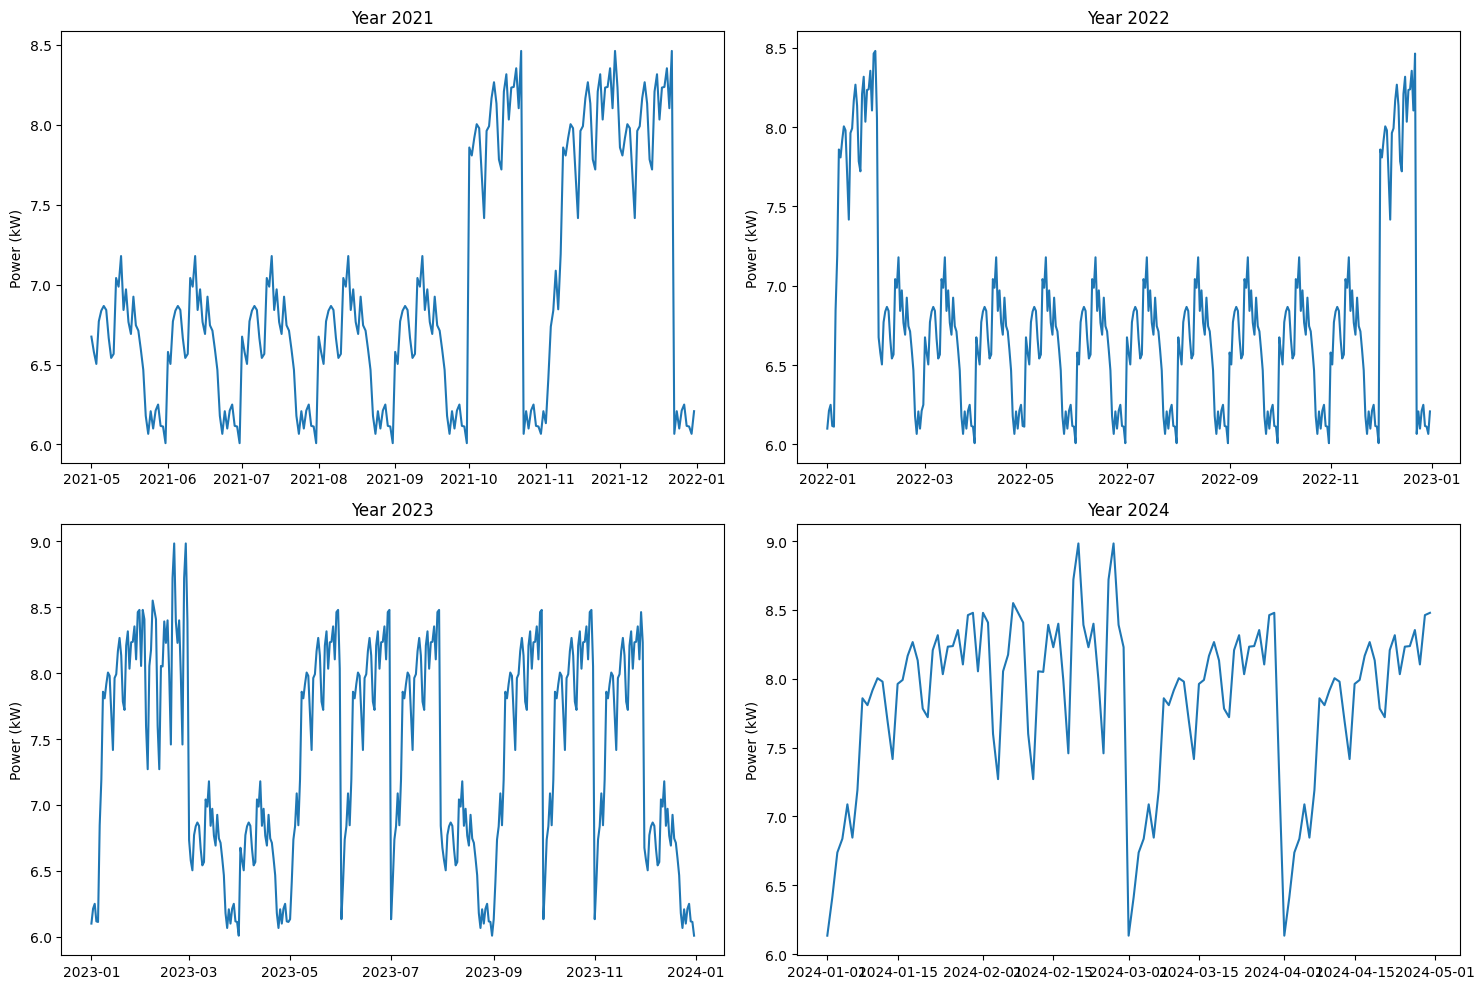

In [ ]:
import matplotlib.pyplot as plt

# Group the data by year
years = bts_data.groupby(bts_data.index.year)

# Calculate the number of rows and columns for the grid
num_years = len(years)
num_cols = 2  # Adjust as needed
num_rows = (num_years + num_cols - 1) // num_cols

# Create the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Iterate over the years and plot each one
for i, (year, data) in enumerate(years):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    ax.plot(data)
    ax.set_title(f'Year {year}')
    ax.set_ylabel('Power (kW)')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

<BarContainer object of 20 artists>

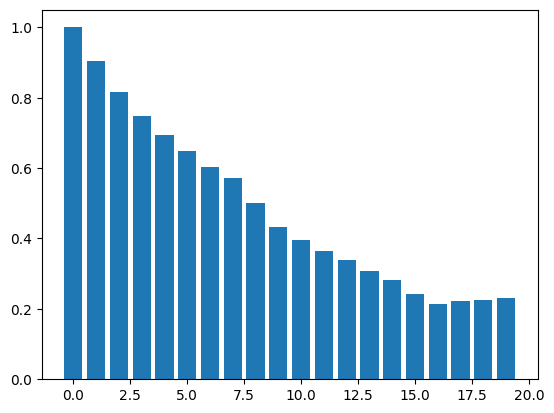

In [ ]:
acf_vals = acf(bts_data)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])

In [ ]:
first_diff = bts_data.diff()[1:]

In [ ]:
first_diff.head()

,Load_Power(kW)
Date,
2021-05-02,-0.095833
2021-05-03,-0.075000
2021-05-04,0.266667
2021-05-05,0.066667
2021-05-06,0.029167


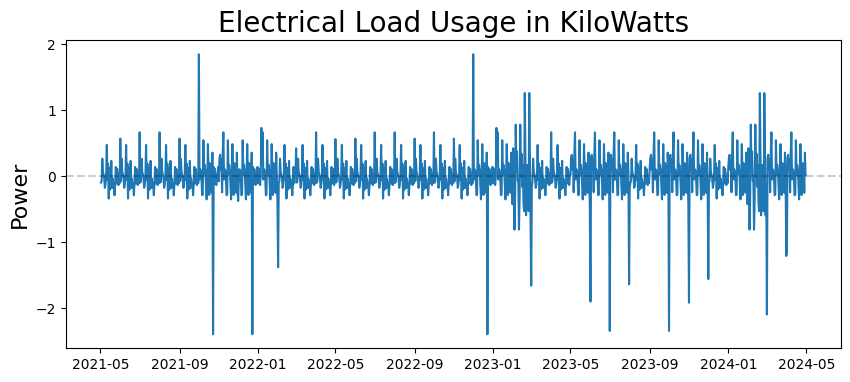

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Electrical Load Usage in KiloWatts', fontsize=20)
plt.ylabel('Power', fontsize=16)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

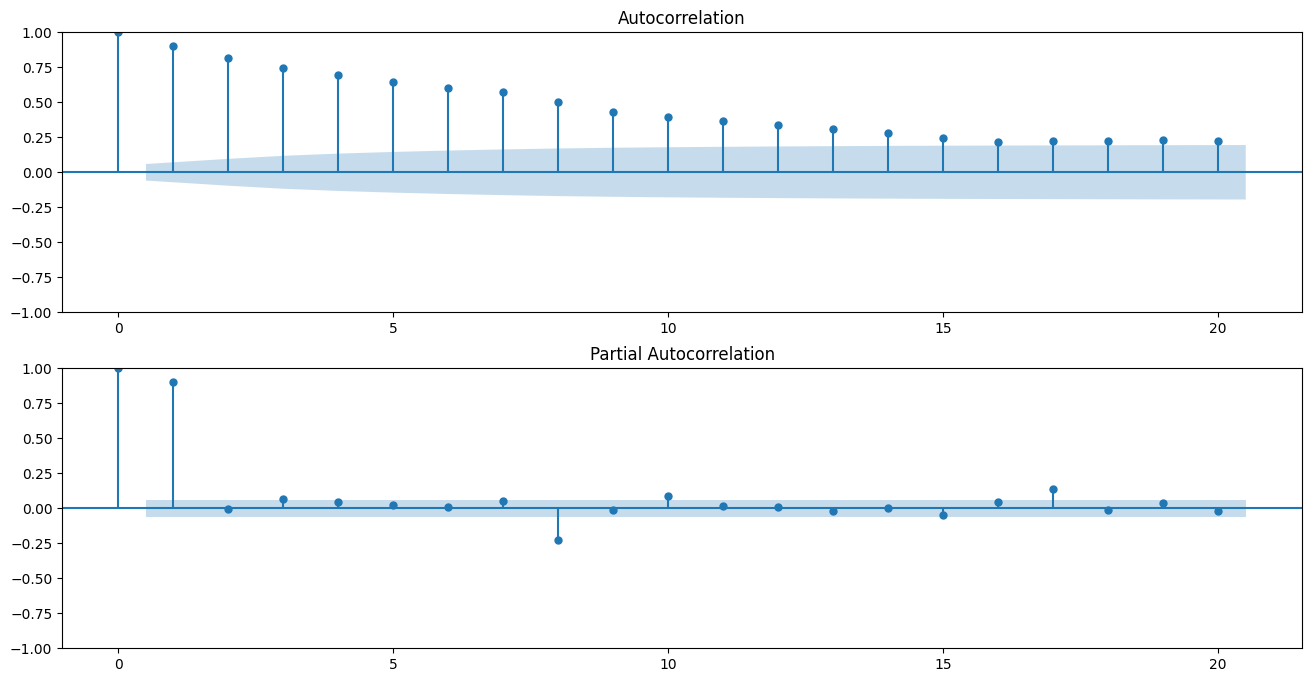

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(bts_data['Load_Power(kW)'], lags=20, ax=ax[0])
plot_pacf(bts_data['Load_Power(kW)'], lags=20, ax=ax[1])

plt.show()

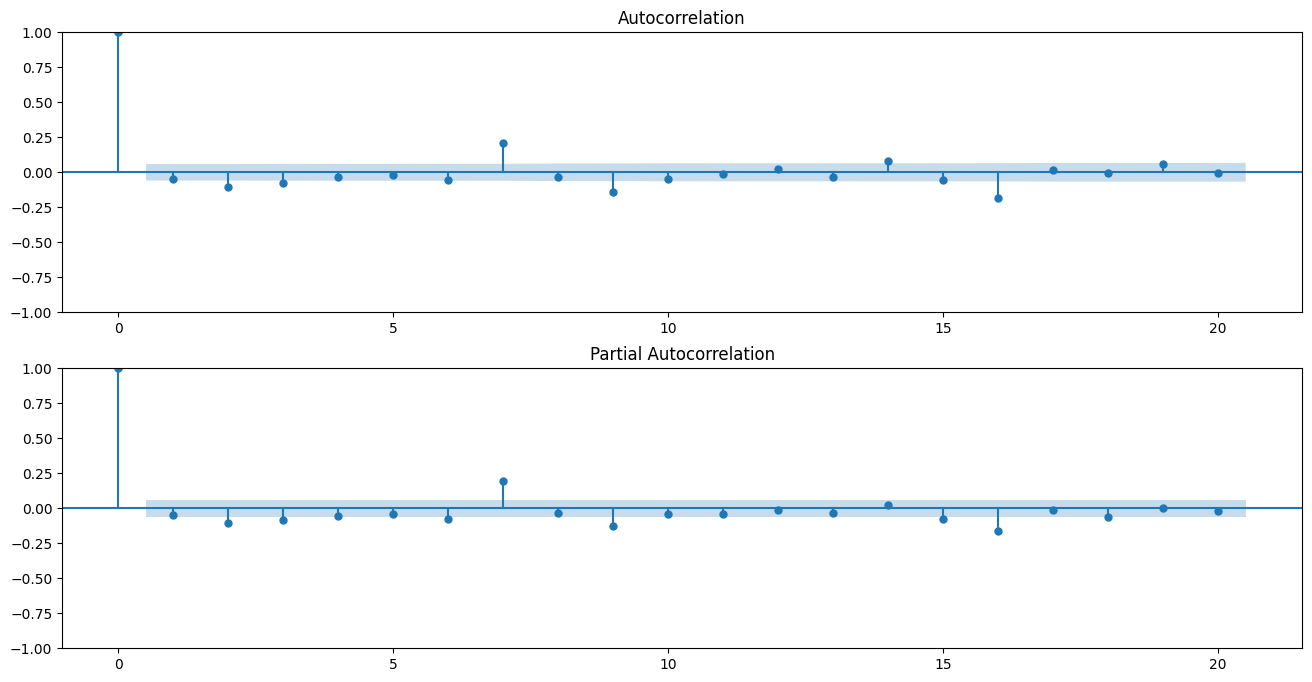

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(first_diff['Load_Power(kW)'], lags=20, ax=ax[0])
plot_pacf(first_diff['Load_Power(kW)'], lags=20, ax=ax[1])

plt.show()

<BarContainer object of 20 artists>

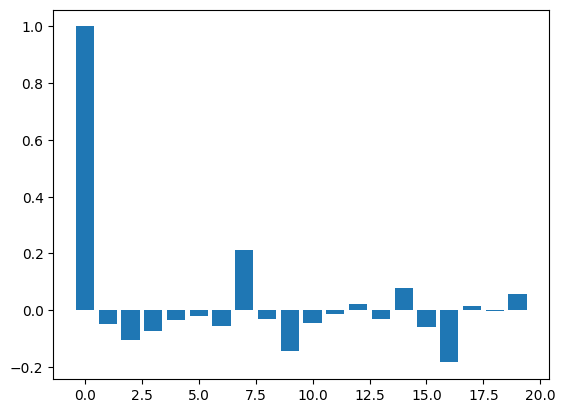

In [ ]:
acf_vals = acf(first_diff)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])

<BarContainer object of 15 artists>

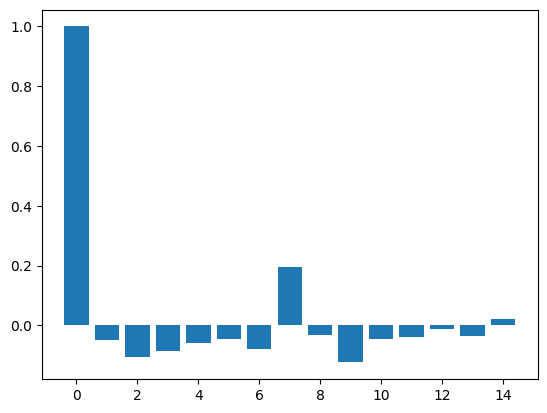

In [ ]:
pacf_vals = pacf(first_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

In [ ]:
train_end = datetime(2024,2,29)
test_end = datetime(2024,4,30)

train_data = bts_data[:train_end]
test_data = bts_data[train_end + timedelta(days=1):test_end]

In [ ]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 7)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [ ]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.5114471912384033


In [ ]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                      Load_Power(kW)   No. Observations:                 1035
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 7)   Log Likelihood                -308.742
Date:                             Sun, 01 Sep 2024   AIC                            623.484
Time:                                     17:46:08   BIC                            638.307
Sample:                                 05-01-2021   HQIC                           629.109
                                      - 02-29-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.5591      0.078      7.192      0.000       0.407       0.712
ma.S.L7       -0.3421      

In [ ]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

In [ ]:
# Assuming 'predictions' and 'test_data' are defined

results_df = pd.DataFrame({
    'Actual': test_data['Load_Power(kW)'],
    'Predicted': predictions
})

print(results_df)

              Actual  Predicted
Date                           
2024-03-01  6.133333   8.276398
2024-03-02  6.412500   8.128552
2024-03-03  6.737500   7.962339
2024-03-04  6.837500   8.358596
2024-03-05  7.087500   8.436167
...              ...        ...
2024-04-26  8.237500   8.217472
2024-04-27  8.354167   8.216059
2024-04-28  8.104167   8.214471
2024-04-29  8.462500   8.218258
2024-04-30  8.479167   8.218999

[61 rows x 2 columns]


In [ ]:
# prompt: write code to save results_df to an excel file

results_df.to_excel('results.xlsx')


Mean Squared Error (MSE): 0.6159628462600987
Root Mean Squared Error (RMSE): 0.7848330053330446
Mean Absolute Error (MAE): 0.5369562565603307
R-squared (R2): -0.6309433419753501


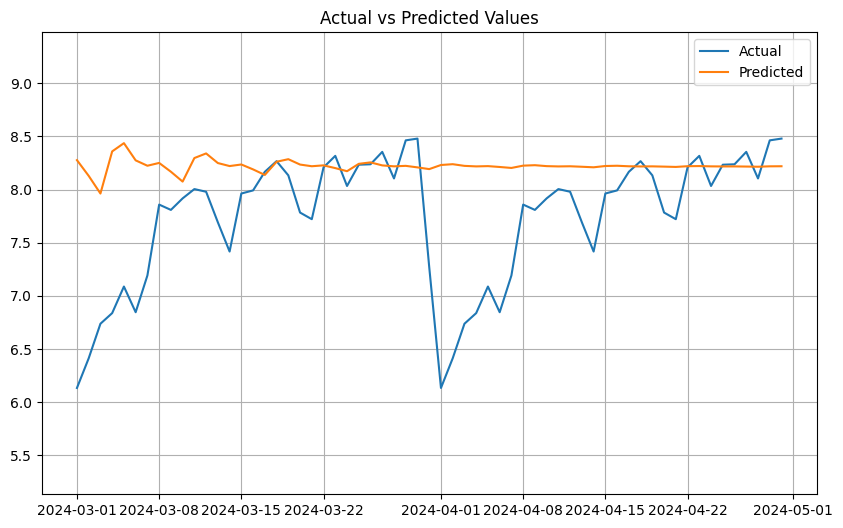

In [ ]:
# prompt: a code that uses all forms of performance meetrics to test the accuracy of the arima model

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate performance metrics
mse = mean_squared_error(test_data['Load_Power(kW)'], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data['Load_Power(kW)'], predictions)
r2 = r2_score(test_data['Load_Power(kW)'], predictions)

# Print the results
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('R-squared (R2):', r2)

# Optional: Plot actual vs predicted values
plt.figure(figsize=(10, 6))
# Get the minimum and maximum values from both actual and predicted data
min_value = min(test_data['Load_Power(kW)'].min(), predictions.min())
max_value = max(test_data['Load_Power(kW)'].max(), predictions.max())

# Set the y-axis limits with some padding
plt.ylim(min_value - 1, max_value + 1)  # Adjust padding as needed

plt.plot(test_data['Load_Power(kW)'], label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.grid(True)
plt.title('Actual vs Predicted Values')
plt.show()


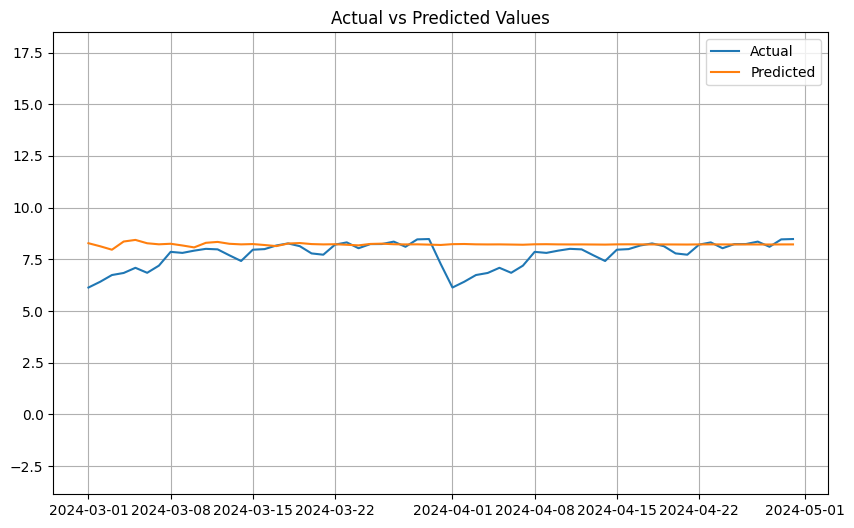

In [ ]:
# prompt: what code can i use to put the minimum and maximum range on the plot

# ... (previous code)

# Calculate performance metrics
# ...

# Optional: Plot actual vs predicted values
plt.figure(figsize=(10, 6))

# Get the minimum and maximum values from both actual and predicted data
min_value = min(test_data['Load_Power(kW)'].min(), predictions.min())
max_value = max(test_data['Load_Power(kW)'].max(), predictions.max())

# Set the y-axis limits with some padding
plt.ylim(min_value - 10, max_value + 10)  # Adjust padding as needed

plt.plot(test_data['Load_Power(kW)'], label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.grid(True)
plt.title('Actual vs Predicted Values')
plt.show()


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Assuming 'test_data' and 'rolling_predictions' are Pandas Series
mape = mean_absolute_percentage_error(test_data, predictions)
print("MAPE:", mape)

MAPE: 7.665328876598536


In [ ]:
predictions.head()

,predicted_mean
Date,
2024-03-01,8.276398
2024-03-02,8.128552
2024-03-03,7.962339
2024-03-04,8.358596
2024-03-05,8.436167


Text(0, 0.5, 'Error')

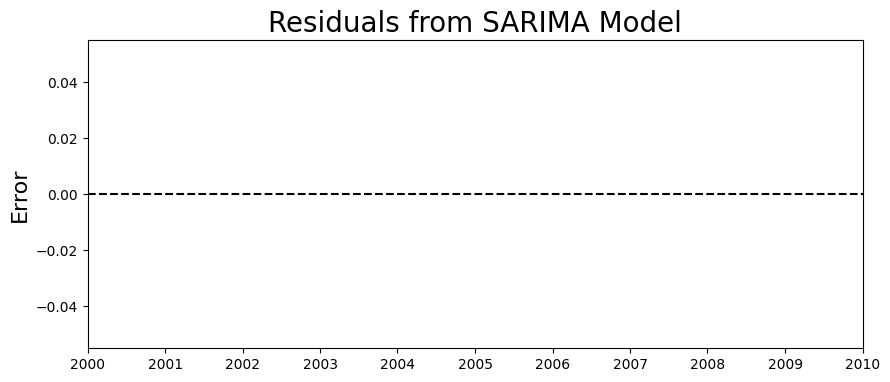

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

Text(0, 0.5, 'Power')

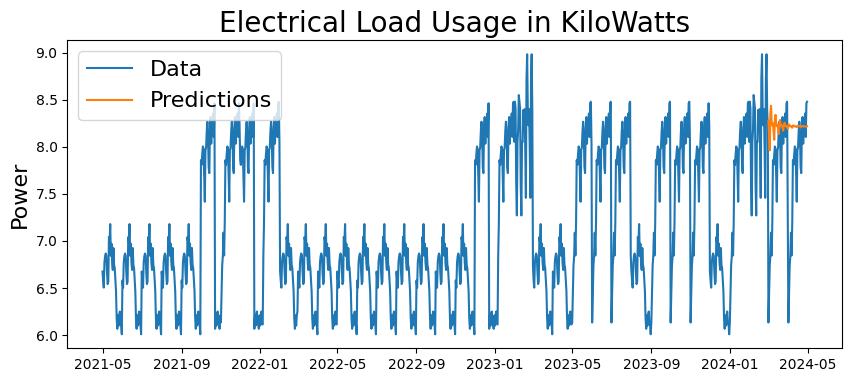

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(bts_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Electrical Load Usage in KiloWatts', fontsize=20)
plt.ylabel('Power', fontsize=16)
#for year in range(start_date.year,end_date.year):
    #plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [ ]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 7)
# define model
model = SARIMAX(bts_data, order=my_order, seasonal_order=my_seasonal_order)

In [ ]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.686220645904541


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


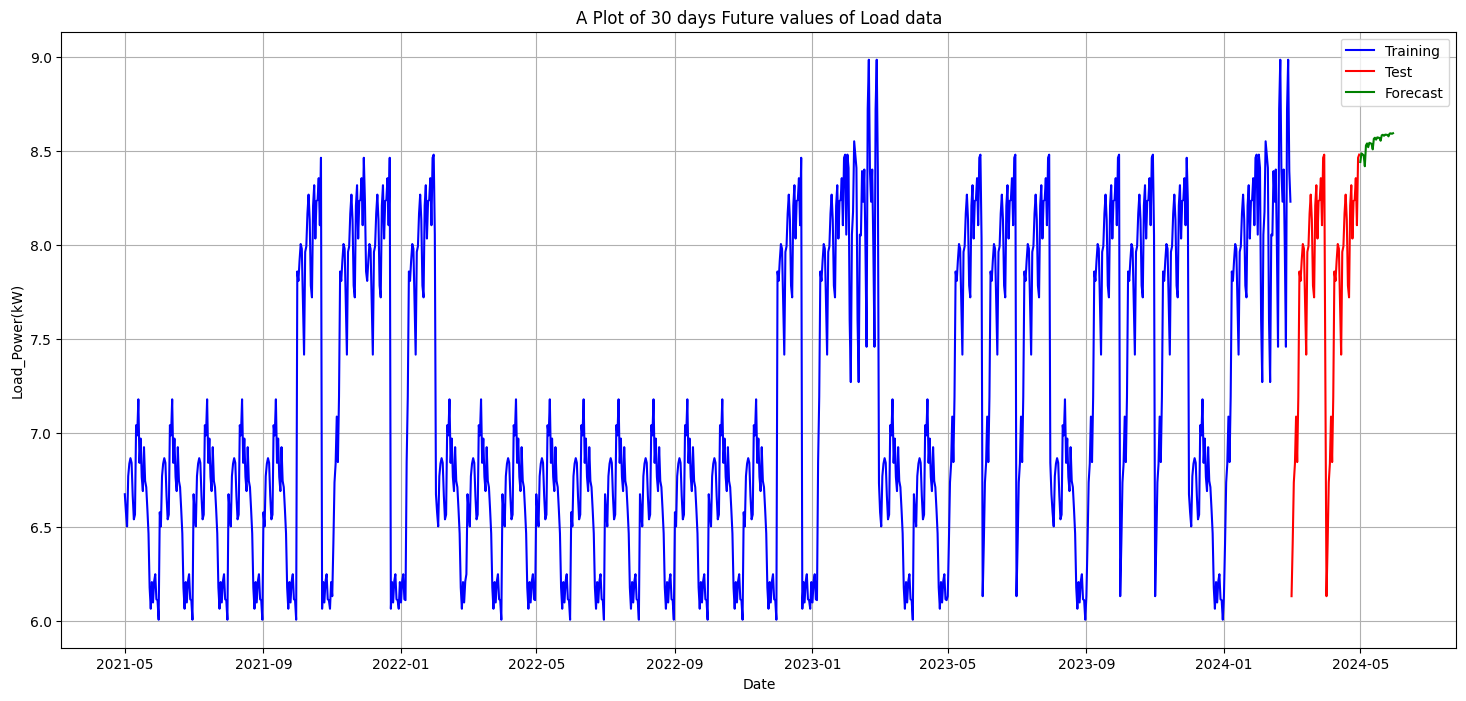

In [ ]:
# Forecast for the next 1 years
forecast = model_fit.predict(start = len(bts_data),
                          end = (len(bts_data)-1) + 30,
                          typ = 'levels').rename('Forecast')

plt.figure(figsize=(18,8))
plt.title('A Plot of 30 days Future values of Load data')
plt.plot(train_data['Load_Power(kW)'], label='Training', color='blue')
plt.plot(test_data['Load_Power(kW)'], label='Test', color='red')
plt.plot(forecast, label='Forecast', color='green')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Load_Power(kW)')
plt.grid()
plt.show()

In [ ]:
forecast

,Forecast
2024-05-01,8.439826
2024-05-02,8.485808
2024-05-03,8.480680
2024-05-04,8.474639
2024-05-05,8.417425
2024-05-06,8.528108
2024-05-07,8.538674
2024-05-08,8.518612
2024-05-09,8.542061
2024-05-10,8.539446
